In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import random
import math


In [330]:
bike = pd.read_csv("bike_rental_hour.csv")

We do some eda first

In [331]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

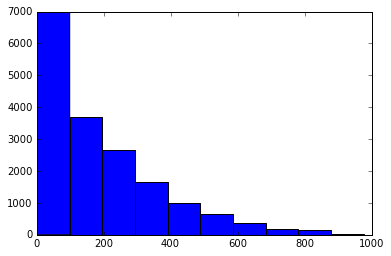

In [332]:
%matplotlib inline
plt.hist(bike['cnt'])

Let's group hours into morning, afternoon...

In [333]:
def assign_label(hour):
    if 6<hour<=12:
        return 1
    elif 12 < hour <= 18:
        return 2
    elif 18< hour <= 24:
        return 3
    else:
        return 4

In [334]:
bike["time_label"] = bike["hr"].apply(assign_label)

In [335]:
cor_df = bike.corr()

In [336]:
cnt_corr = abs(cor_df["cnt"]).sort_values(ascending = False)

In [337]:
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
time_label    0.494422
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Splitting the data into training and test sets

In [338]:
bike.shape[0] * 0.8

13903.2

In [339]:
random.seed(1)
bike = bike.reindex(np.random.permutation(bike.shape[0]))

In [340]:
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
10803,10804,2012-03-31,2,1,3,6,0,6,0,2,0.36,0.3485,0.87,0.1642,7,16,23,4
11940,11941,2012-05-17,2,1,5,17,0,4,1,1,0.66,0.6212,0.31,0.1343,133,719,852,2
15347,15348,2012-10-06,4,1,10,16,0,6,0,1,0.60,0.6212,0.43,0.5224,317,342,659,2
14322,14323,2012-08-24,3,1,8,23,0,5,1,2,0.68,0.6364,0.69,0.0896,38,140,178,3
1399,1400,2011-03-03,1,0,3,14,0,4,1,1,0.24,0.2576,0.21,0.1045,18,60,78,2


In [341]:
train = bike.iloc[0:13903,]
test = bike.iloc[13903:,]

Now we perform some basic variable selection and cleaning

In [342]:
## remove variables that have corr <0.05

columns = cnt_corr[cnt_corr > 0.05].index

## remove cnt, casual, registered, instant

columns = columns.drop(["cnt", "registered", "casual", "instant"])

## remove temp as we have atemp, also removing hr since we grouped them

columns = columns.drop(["temp", "hr"])


In [343]:
columns

Index(['time_label', 'atemp', 'hum', 'yr', 'season', 'weathersit', 'mnth',
       'windspeed'],
      dtype='object')

Now let's run a basic regression

In [344]:
model1 = LinearRegression()
model1.fit(train[columns], train["cnt"])
test["prediction1"] = model1.predict(test[columns])
rme1 = math.sqrt(mean_squared_error(test["cnt"], test["prediction1"]))

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [345]:
rme = {}
rme["LinearReg"] = rme1

In [346]:
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,prediction1
5916,5917,2011-09-09,3,0,9,1,0,5,1,2,0.62,0.5152,1.00,0.1642,0,8,8,4,1.234099
6583,6584,2011-10-06,4,0,10,21,0,4,1,1,0.46,0.4545,0.88,0.0896,34,161,195,3,100.056315
10917,10918,2012-04-05,2,1,4,1,0,4,1,1,0.48,0.4697,0.27,0.3284,4,9,13,4,193.065199
3576,3577,2011-06-02,2,0,6,22,0,4,1,1,0.64,0.6212,0.33,0.2537,14,141,155,3,211.531424
1975,1976,2011-03-28,2,0,3,3,0,1,1,1,0.22,0.2273,0.44,0.1642,0,2,2,4,2.429544


Next, we will use dummies for categorical variables, and see if we can have some improvements

In [347]:
cate = ["time_label", "yr", "season", "weathersit", "mnth"]

In [348]:
train_cate = train.copy()
test_cate = test.copy()

In [349]:
train_dummies = pd.get_dummies(train_cate, prefix = cate, columns = cate)
test_dummies = pd.get_dummies(test_cate, prefix = cate, columns = cate)


    

In [350]:
columns_cate = train_dummies.columns

In [351]:
columns_cate = columns_cate.drop(["instant", "dteday", "hr", "holiday", "weekday", "workingday", "temp", "casual", "registered", "cnt"])


In [352]:
columns_cate

Index(['atemp', 'hum', 'windspeed', 'time_label_1', 'time_label_2',
       'time_label_3', 'time_label_4', 'yr_0', 'yr_1', 'season_1', 'season_2',
       'season_3', 'season_4', 'weathersit_1', 'weathersit_2', 'weathersit_3',
       'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12'],
      dtype='object')

Now, we fit a second regression with dummies

In [353]:
model2 = LinearRegression()
model2.fit(train_dummies[columns_cate], train_dummies["cnt"])
test["prediction2"] = model2.predict(test_dummies[columns_cate])

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [354]:
test.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,prediction1,prediction2
5916,5917,2011-09-09,3,0,9,1,0,5,1,2,0.62,0.5152,1.00,0.1642,0,8,8,4,1.234099,7.953125
6583,6584,2011-10-06,4,0,10,21,0,4,1,1,0.46,0.4545,0.88,0.0896,34,161,195,3,100.056315,168.640625
10917,10918,2012-04-05,2,1,4,1,0,4,1,1,0.48,0.4697,0.27,0.3284,4,9,13,4,193.065199,125.703125
3576,3577,2011-06-02,2,0,6,22,0,4,1,1,0.64,0.6212,0.33,0.2537,14,141,155,3,211.531424,217.546875
1975,1976,2011-03-28,2,0,3,3,0,1,1,1,0.22,0.2273,0.44,0.1642,0,2,2,4,2.429544,-14.015625


In [355]:
rme2 = math.sqrt(mean_squared_error(test["cnt"], test["prediction2"]))

In [356]:
rme["Regression_with_dummies"] = rme2

Next, I would see if any numerical variables need any transformation

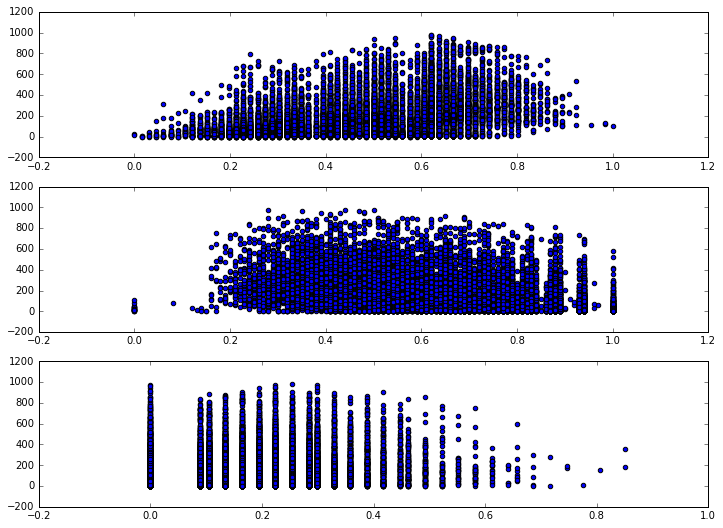

In [357]:
## plot y vs numerical variables

fig = plt.figure(figsize = (12,12))
axe1 = fig.add_subplot(4,1,1)
axe2 = fig.add_subplot(4,1,2)
axe3 = fig.add_subplot(4,1,3)
axe1.scatter(train["atemp"], train["cnt"])
axe2.scatter(train["hum"], train["cnt"])
axe3.scatter(train["windspeed"], train["cnt"])



(array([ 128.,  344.,  730.,  821.,  984., 1278., 2061., 3379., 3066.,
        1112.]),
 array([0.        , 0.68844867, 1.37689733, 2.065346  , 2.75379466,
        3.44224333, 4.13069199, 4.81914066, 5.50758932, 6.19603799,
        6.88448665]),
 <a list of 10 Patch objects>)

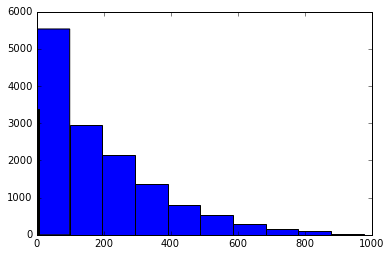

In [358]:
plt.hist(train["cnt"])
plt.hist(np.log(train["cnt"]))

(array([ 128.,  344.,  730.,  821.,  984., 1278., 2061., 3379., 3066.,
        1112.]),
 array([0.        , 0.68844867, 1.37689733, 2.065346  , 2.75379466,
        3.44224333, 4.13069199, 4.81914066, 5.50758932, 6.19603799,
        6.88448665]),
 <a list of 10 Patch objects>)

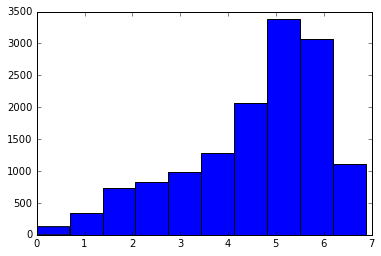

In [359]:
plt.hist(np.log(train["cnt"]))

There seems to be no need to transform x, but y seems to be very skewed, and log it should help

In [360]:
train_dummies["log_cnt"] = np.log(train_dummies["cnt"])
test_dummies["log_cnt"] = np.log(test_dummies["cnt"])

In [361]:
# fit on log_cnt, and exponentiate predictions 

model3 = LinearRegression()
model3.fit(train_dummies[columns_cate], train_dummies["log_cnt"])
pred = model3.predict(test_dummies[columns_cate])
test["prediction3"] = np.exp(pred)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [362]:
test.head(20)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,time_label,prediction1,prediction2,prediction3
5916,5917,2011-09-09,3,0,9,1,0,5,1,2,...,0.5152,1.00,0.1642,0,8,8,4,1.234099,7.953125,15.113315
6583,6584,2011-10-06,4,0,10,21,0,4,1,1,...,0.4545,0.88,0.0896,34,161,195,3,100.056315,168.640625,132.582757
10917,10918,2012-04-05,2,1,4,1,0,4,1,1,...,0.4697,0.27,0.3284,4,9,13,4,193.065199,125.703125,26.693600
3576,3577,2011-06-02,2,0,6,22,0,4,1,1,...,0.6212,0.33,0.2537,14,141,155,3,211.531424,217.546875,177.497243
1975,1976,2011-03-28,2,0,3,3,0,1,1,1,...,0.2273,0.44,0.1642,0,2,2,4,2.429544,-14.015625,11.438807
15092,15093,2012-09-26,4,1,9,1,0,3,1,1,...,0.5455,0.64,0.3284,10,19,29,4,191.601992,176.250000,37.451504
3882,3883,2011-06-15,2,0,6,16,0,3,1,1,...,0.6667,0.27,0.1343,47,265,312,2,299.759190,354.406250,324.401654
12953,12954,2012-06-28,3,1,6,22,0,4,1,1,...,0.6970,0.52,0.1642,50,224,274,3,303.620999,303.171875,314.958664
5590,5591,2011-08-25,3,0,8,20,0,4,1,1,...,0.5909,0.78,0.3582,33,192,225,3,146.155617,171.000000,136.624506
8548,8549,2011-12-27,1,0,12,22,0,2,1,1,...,0.3333,0.87,0.0896,3,29,32,3,1.553266,45.671875,56.262560


In [363]:
rme["Regression_log_cnt"] = math.sqrt(mean_squared_error(test["cnt"], test["prediction3"]))

In [364]:
rme

{'LinearReg': 131.94124228238326,
 'Regression_log_cnt': 120.70500707242941,
 'Regression_with_dummies': 121.43658928032261}

Seems like not a huge improvement, so now we can try trees

In [365]:
model4 = DecisionTreeRegressor()
model4.fit(train[columns], train["cnt"])
test["prediction4"] = model4.predict(test[columns])

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [366]:
rme["Full_tree"] = math.sqrt(mean_squared_error(test["cnt"], test["prediction4"]))

In [367]:
## check if it's overfitting (training error vs testing error)
train_pred = model4.predict(train[columns])
train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))


In [368]:
print("training rme is " + str(train_rme))
print("testing rme is " + str(rme["Full_tree"]))

training rme is 22.778030536156813
testing rme is 148.38503797024532


It's clearly overfitting, so let's try to tune the model so it performs better on test set

In [369]:
def gridsearch(min_samples_leaf, max_depth):
    model = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    model.fit(train[columns], train["cnt"])
    test_pred = model.predict(test[columns])
    test_rme = math.sqrt(mean_squared_error(test["cnt"], test_pred))

### check training and testing error again
    train_pred = model.predict(train[columns])
    train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))

    print( "min samples = " + str(min_samples_leaf) + ", max depth = " +str(max_depth) +", training rme is " + str(round(train_rme,2)) + ", testing rme is " + str(round(test_rme,2)))

    

In [370]:
for i in range(20, 200, 30):
    for j in range (5, 30, 5):
        gridsearch(min_samples_leaf = i, max_depth = j)

min samples = 20, max depth = 5, training rme is 117.91, testing rme is 117.72
min samples = 20, max depth = 10, training rme is 107.11, testing rme is 109.78
min samples = 20, max depth = 15, training rme is 103.38, testing rme is 111.99
min samples = 20, max depth = 20, training rme is 103.01, testing rme is 112.03
min samples = 20, max depth = 25, training rme is 103.01, testing rme is 112.03
min samples = 50, max depth = 5, training rme is 117.91, testing rme is 117.71
min samples = 50, max depth = 10, training rme is 109.05, testing rme is 110.64
min samples = 50, max depth = 15, training rme is 108.2, testing rme is 110.6
min samples = 50, max depth = 20, training rme is 108.2, testing rme is 110.6
min samples = 50, max depth = 25, training rme is 108.2, testing rme is 110.6
min samples = 80, max depth = 5, training rme is 117.92, testing rme is 117.72
min samples = 80, max depth = 10, training rme is 110.92, testing rme is 111.69
min samples = 80, max depth = 15, training rme is

It seems like best value is min samples per leaf = 20, and max depth of the tree is 10, so let's do that

In [371]:
model5 = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 20)
model5.fit(train[columns], train["cnt"])
test["prediction5"] = model5.predict(test[columns])
rme ["Tuned_tree"] = math.sqrt(mean_squared_error(test["cnt"], test["prediction5"]))

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [372]:
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,time_label,prediction1,prediction2,prediction3,prediction4,prediction5
5916,5917,2011-09-09,3,0,9,1,0,5,1,2,...,0.1642,0,8,8,4,1.234099,7.953125,15.113315,31.0,31.936255
6583,6584,2011-10-06,4,0,10,21,0,4,1,1,...,0.0896,34,161,195,3,100.056315,168.640625,132.582757,99.0,108.315789
10917,10918,2012-04-05,2,1,4,1,0,4,1,1,...,0.3284,4,9,13,4,193.065199,125.703125,26.693600,14.0,33.692308
3576,3577,2011-06-02,2,0,6,22,0,4,1,1,...,0.2537,14,141,155,3,211.531424,217.546875,177.497243,423.0,208.047619
1975,1976,2011-03-28,2,0,3,3,0,1,1,1,...,0.1642,0,2,2,4,2.429544,-14.015625,11.438807,5.0,14.619048


Next, random forest

In [373]:
model6 = RandomForestRegressor(n_estimators = 1500, max_depth = 10, min_samples_leaf = 20)
model6.fit(train[columns], train["cnt"])
test["prediction6"] = model6.predict(test[columns])
rme ["random_forest"] = math.sqrt(mean_squared_error(test["cnt"], test["prediction6"]))


/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [374]:
rme

{'Full_tree': 148.38503797024532,
 'LinearReg': 131.94124228238326,
 'Regression_log_cnt': 120.70500707242941,
 'Regression_with_dummies': 121.43658928032261,
 'Tuned_tree': 109.77878039971367,
 'random_forest': 108.00040355931955}

In [375]:
# check if random forest is overfitting

train_pred = model6.predict(train[columns])
train_rme = math.sqrt(mean_squared_error(train["cnt"], train_pred))

train_rme


105.09866381845403

We are done! We will use the predictions given by random forest (prediction6). Finally, let's calculate the mean absolute error to see how much we are off on average!

In [378]:
print(mean_absolute_error(test["cnt"], test["prediction6"]))

75.57894860682767


In [379]:
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,casual,registered,cnt,time_label,prediction1,prediction2,prediction3,prediction4,prediction5,prediction6
5916,5917,2011-09-09,3,0,9,1,0,5,1,2,...,0,8,8,4,1.234099,7.953125,15.113315,31.0,31.936255,26.289555
6583,6584,2011-10-06,4,0,10,21,0,4,1,1,...,34,161,195,3,100.056315,168.640625,132.582757,99.0,108.315789,110.937581
10917,10918,2012-04-05,2,1,4,1,0,4,1,1,...,4,9,13,4,193.065199,125.703125,26.693600,14.0,33.692308,41.425419
3576,3577,2011-06-02,2,0,6,22,0,4,1,1,...,14,141,155,3,211.531424,217.546875,177.497243,423.0,208.047619,243.761042
1975,1976,2011-03-28,2,0,3,3,0,1,1,1,...,0,2,2,4,2.429544,-14.015625,11.438807,5.0,14.619048,12.012611
